In [20]:
import json
from tqdm import tqdm
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import random
from sklearn.manifold import TSNE
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, Lambda, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [2]:
def load_json_objects(file_path, limit=10000):
    data = []
    with open(file_path, 'r') as file:
        for i, line in tqdm(enumerate(file)):
            if i >= limit:
                break
            data.append(json.loads(line))
    return data

In [3]:
file_path = 'Software.json'

software_data = load_json_objects(file_path)

10000it [00:00, 64576.43it/s]


In [4]:
filtered_reviews = []

# select only the information needed from the json file
for review in software_data:
    filtered_review = {
        'overall': review.get('overall'),
        'asin': review.get('asin'),
        'reviewText': review.get('reviewText'),
        'summary': review.get('summary')
    }
    filtered_reviews.append(filtered_review)

In [5]:
df_reviews = pd.DataFrame(filtered_reviews)
df_reviews = df_reviews[df_reviews['reviewText'].apply(lambda x: isinstance(x, str))]

df_reviews = df_reviews.reset_index(drop=True)

In [9]:
row = df_reviews.iloc[20]

print("Review Summary:")
print(f"Overall Rating: {row['overall']}")
print(f"ASIN: {row['asin']}")
print(f"Review Text: {row['reviewText']}")
print(f"Summary: {row['summary']}")

Review Summary:
Overall Rating: 4.0
ASIN: 0132147556
Review Text: This book provides me many useful knowledge about E-marketing, from the most basic steps. So I really enjoy to read!
Summary: E-marketing


In [91]:
df_reviews

,overall,asin,reviewText,summary,Class
0,4.0,0077613252,The materials arrived early and were in excell...,Material Great,Good
1,4.0,0077613252,I am really enjoying this book with the worksh...,Health,Good
2,1.0,0077613252,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,Bad
3,3.0,0077613252,This book was missing pages!!! Important pages...,missing pages!!,Bad
4,5.0,0077775473,I have used LearnSmart and can officially say ...,Best study product out there!,Good
...,...,...,...,...,...
9995,5.0,B000069IL7,"I loved it at the time, but as you know you al...",I loved it,Good
9996,5.0,B000069IL7,It works the way that I hoped it would. It has...,a ok,Good
9997,5.0,B000069IL7,I installed this suite on an IBM with a stripp...,Neat Programs....however,Good
9998,1.0,B000069IL7,I loaded Word 2002 only. It caused the process...,Microsoft works 2003,Bad


In [92]:
df_reviews[['overall','reviewText']]

,overall,reviewText
0,4.0,The materials arrived early and were in excell...
1,4.0,I am really enjoying this book with the worksh...
2,1.0,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,3.0,This book was missing pages!!! Important pages...
4,5.0,I have used LearnSmart and can officially say ...
...,...,...
9995,5.0,"I loved it at the time, but as you know you al..."
9996,5.0,It works the way that I hoped it would. It has...
9997,5.0,I installed this suite on an IBM with a stripp...
9998,1.0,I loaded Word 2002 only. It caused the process...


The Amazon review dataset has detailed customer feedback for various products sold on Amazon. This particular dataset is for software products such as microsoft office.  Each entry in the dataset includes fields: an overall rating, a unique product identifier (ASIN), the textual content of the review, and a concise summary of the review. The "overall" rating is the value the customer assigned to the product on a scale from 1 to 5. The "ASIN" is Amazon's unique code for identifying products. In future works, we could analyze different ASIN groups to see what they have in common. "ReviewText" contains the customer's comment, while "summary" offers a shorter overview of the review.

## Exploratory Data Analysis and Coverage Analysis

In [26]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def simple_tokenize(text):
    tokens = text.lower().split()
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# extract all words and remove broken comments
all_words = [word for review in df_reviews['reviewText'] if isinstance(review, str) for word in simple_tokenize(review)]

# count word frequency
word_counts = Counter(all_words)
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# calculate coverage
total_words = sum(word_counts.values())
coverage = []
cumulative_coverage = 0
for word, count in sorted_words:
    cumulative_coverage += count / total_words
    coverage.append(cumulative_coverage)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tzhori.i/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


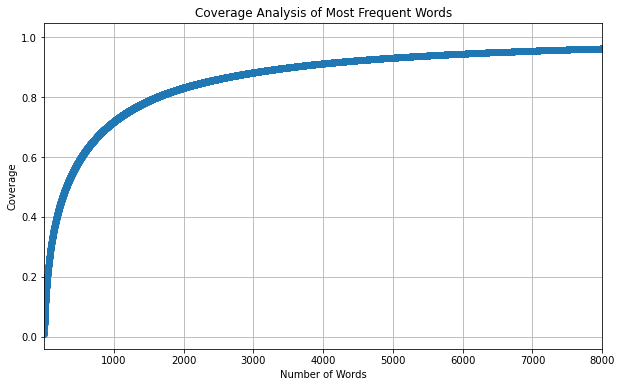

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverage) + 1), coverage, marker='o')
plt.xlabel('Number of Words')
plt.xlim(1, 8000)
plt.ylabel('Coverage')
plt.title('Coverage Analysis of Most Frequent Words')
plt.grid(True)
plt.show()

In this coverage analysis of the corpus of Amazon refies, Zipf's Law can be observed. In the project, I used the entire corpus, but in future works, a smaller portion of the corpus can be used to save on time and memory issues.

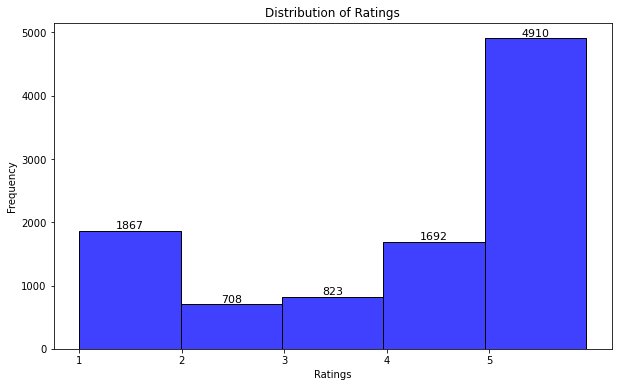

In [28]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_reviews, x='overall', bins=5, binwidth=0.99, kde=False, color='blue')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.show()

## Skipgram Word Embeddings

In [29]:
reviews = [review for review in df_reviews.reviewText]
print(f"Total number of reviews in the dataset: {len(reviews)}")


Total number of reviews in the dataset: 10000


In [30]:
class SkipGram(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        # embedding layer to convert word indices to dense vectors
        self.embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)
        self.dense = Dense(vocab_size, activation='softmax')
        # reshape layer to ensure the correct shape
        self.reshape = Reshape(target_shape=(embedding_dim,))

    def call(self, inputs):
        # pass the input through the embedding layer
        x = self.embedding(inputs)
        # reshape the embedding output to fit the dense layer input
        x = self.reshape(x)
        # dense layer to predict the context words
        return self.dense(x)

I used the skipgram model as it was observed to be slightly better than the CBOW implementation

In [31]:
# Define a function to convert a word to its index in the vocabulary
def word_to_index(word, vocab):
    return vocab.index(word)

In [32]:
tokenized_sentences = []
for review in tqdm(reviews):
    sentences = sent_tokenize(review)
    for sentence in sentences:
        # remove punctuation from each sentence and tokenize it
        words = word_tokenize(re.sub(r'[^\w\s]', '', sentence.lower()))
        words = [word for word in words if word not in stop_words]
        tokenized_sentences.append(words)

# build the vocabulary
word_counts = Counter(word for sentence in tokenized_sentences for word in sentence)
vocab = list(word_counts.keys())

# mapping dictionaries
w2i = {word: index for index, word in enumerate(vocab)}
i2w = {index: word for index, word in enumerate(vocab)}

window_size = 3

# training data for skipgram
data = [(sentence[target_index], context_word)
        for sentence in tokenized_sentences
        for target_index in range(window_size, len(sentence) - window_size)
        for context_word in sentence[target_index - window_size:target_index] + sentence[target_index + 1:target_index + window_size + 1]]

X_skipgram = np.zeros((len(data), 1), dtype=int)
y_skipgram = np.zeros((len(data), 1), dtype=int)

for i, (target, context) in enumerate(data):
    X_skipgram[i] = w2i[target]
    y_skipgram[i] = w2i[context]

100%|██████████| 10000/10000 [00:12<00:00, 826.47it/s]


Here I prepare the data for a skipgram mode. I chose the window szie as 3 since this showed the best balance of model accuracy and computational effort

In [33]:
print(f"Shape of X_skipgram (input features): {X_skipgram.shape}")
print(f"Shape of y_skipgram (target features): {y_skipgram.shape}")

Shape of X_skipgram (input features): (1327122, 1)
Shape of y_skipgram (target features): (1327122, 1)


In [34]:
# print example data

for i in range(10):
    print(f"data {i} --- target:'{vocab[X_skipgram[i][0]]}' --- context: '{vocab[y_skipgram[i][0]]}'")

data 0 --- target:'really' --- context: 'however'
data 1 --- target:'really' --- context: 'money'
data 2 --- target:'really' --- context: 'spent'
data 3 --- target:'really' --- context: 'shouldve'
data 4 --- target:'really' --- context: 'come'
data 5 --- target:'really' --- context: 'binder'
data 6 --- target:'shouldve' --- context: 'money'
data 7 --- target:'shouldve' --- context: 'spent'
data 8 --- target:'shouldve' --- context: 'really'
data 9 --- target:'shouldve' --- context: 'come'


In [99]:
embedding_dim = 100 # size of embedding vector
vocab_size = len(vocab)
skipgram_model = SkipGram(vocab_size, embedding_dim)

optimizer = Adam(learning_rate=0.001)
skipgram_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = skipgram_model.fit(X_skipgram, y_skipgram, epochs=50, batch_size=8096)

Epoch 1/50
164/164 [==============================] - 45s 272ms/step - loss: 9.6478 - accuracy: 0.0072
Epoch 2/50
164/164 [==============================] - 45s 274ms/step - loss: 8.1450 - accuracy: 0.0075
Epoch 3/50
164/164 [==============================] - 45s 275ms/step - loss: 8.0317 - accuracy: 0.0088
Epoch 4/50
164/164 [==============================] - 45s 276ms/step - loss: 7.9816 - accuracy: 0.0111
Epoch 5/50
164/164 [==============================] - 45s 277ms/step - loss: 7.9372 - accuracy: 0.0129
Epoch 6/50
164/164 [==============================] - 45s 277ms/step - loss: 7.8910 - accuracy: 0.0146
Epoch 7/50
164/164 [==============================] - 45s 277ms/step - loss: 7.8426 - accuracy: 0.0162
Epoch 8/50
164/164 [==============================] - 45s 277ms/step - loss: 7.7914 - accuracy: 0.0178
Epoch 9/50
164/164 [==============================] - 45s 277ms/step - loss: 7.7384 - accuracy: 0.0193
Epoch 10/50
164/164 [==============================] - 46s 278ms/step - l

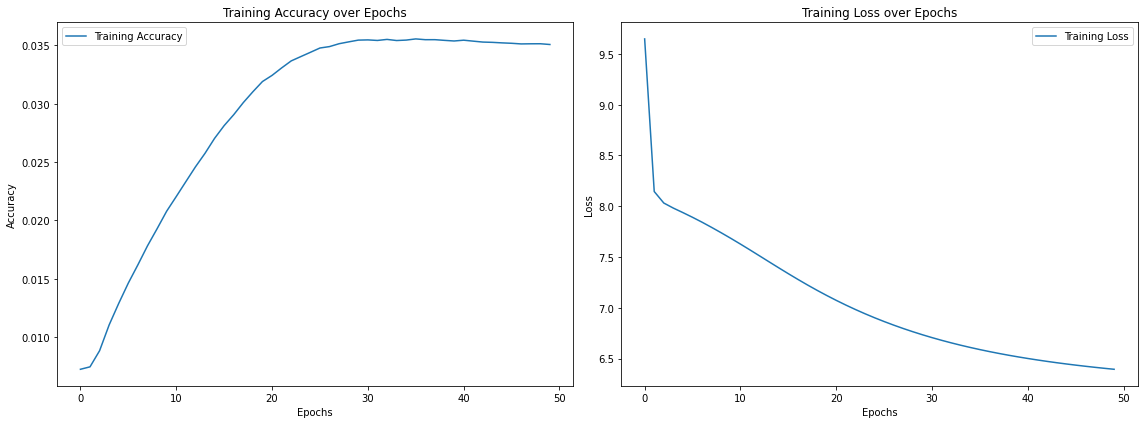

In [100]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].set_title('Training Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].set_title('Training Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

As can be seen in the plots, the loss decreases with each epoch and eventually plateaus during the final epochs. This means that the model is converging to its optimal state. Simultaneously, the training accuracy increases with each epoch, which is an expected behavior as the model learns and adapts to the data.

## TSNE 

This portion was to test to see if the word embeddings have understood the overall sentiment and language of the review. By averaging the embeddings of all words in a review, I got a single vector that represents the entire review. This average embedding captures the overall sentiment and thematic content of the review. The goal here is to visually assess whether reviews with different ratings cluster separately. If reviews of different ratings form distinct clusters on the 2D plot, this means that the embeddings have effectively captured the underlying sentiment and language tied to each rating level

In [43]:
# convert a review to it's vector representation
def review_to_vector(review, vocab, skipgram_model, embedding_dim):
    # Tokenize and remove stopwords
    words = [word for word in word_tokenize(review.lower()) if word not in stop_words and word in vocab]
    word_indices = [word_to_index(word, vocab) for word in words]
    
    if not words:  # check if list is empty after removing stopwords
        return np.zeros(embedding_dim)
    word_embeddings = skipgram_model.embedding(np.array(word_indices)).numpy()
    return np.mean(word_embeddings, axis=0) # return the average of the reviews embeddings

# convert reviews to vectors
review_vectors = []
for review in tqdm(df_reviews.reviewText):
    review_vector = review_to_vector(review, vocab, skipgram_model, embedding_dim)
    review_vectors.append(review_vector)

100%|██████████| 10000/10000 [03:15<00:00, 51.14it/s]


In [44]:
# reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
review_vectors_2d = tsne.fit_transform(review_vectors)

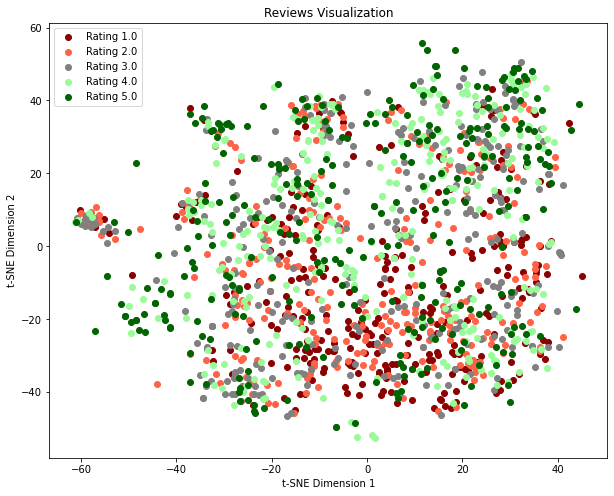

In [45]:
df_plot = pd.DataFrame({'X': review_vectors_2d[:, 0], 'Y': review_vectors_2d[:, 1], 'Rating': df_reviews.overall})

# sample data points from each rating category
sampled_df = df_plot.groupby('Rating').apply(lambda x: x.sample(n=300, random_state=42)).reset_index(drop=True)

color_map = {
    1.0: '#8B0000',  
    2.0: '#FF6347',
    3.0: '#808080',
    4.0: '#98FB98',
    5.0: '#006400' 
}


plt.figure(figsize=(10, 8))
for rating in sampled_df['Rating'].unique():
    data = sampled_df[sampled_df['Rating'] == rating]
    plt.scatter(data['X'], data['Y'], color=color_map[rating], label=f'Rating {rating}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Reviews Visualization')
plt.legend()
plt.show()

It's hard to tell, but there is some clustering of the reviews

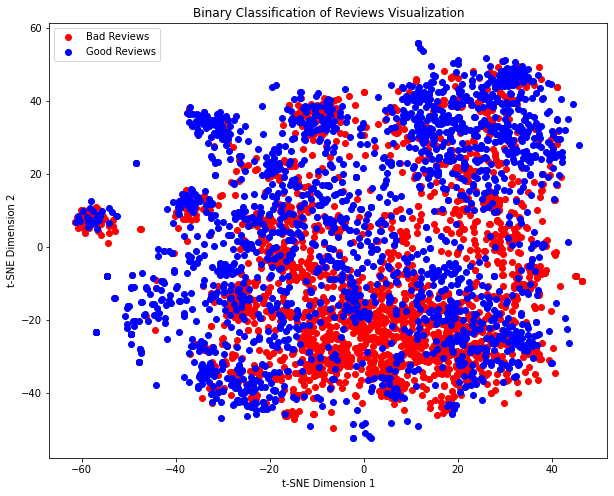

In [55]:
df_reviews['Class'] = df_reviews['overall'].copy().apply(lambda x: 'Good' if x >= 4 else 'Bad')

df_plot = pd.DataFrame({
    'X': review_vectors_2d[:, 0],
    'Y': review_vectors_2d[:, 1],
    'Class': df_reviews['Class']
})

sampled_df = df_plot.groupby('Class').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)

color_map = {'Good': 'blue', 'Bad': 'red'}

plt.figure(figsize=(10, 8))
for cls in sampled_df['Class'].unique():
    data = sampled_df[sampled_df['Class'] == cls]
    plt.scatter(data['X'], data['Y'], color=color_map[cls], label=f'{cls} Reviews', alpha = 1)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Binary Classification of Reviews Visualization')
plt.legend()
plt.show()

This binary classification simplifies the analysis and makes the clusters more interpretable by focusing on overall sentiment (good vs bad). I consider a good review as one that got a 4 or 5 start rating, while the bad reviews are those that got 1, 2, or 3. Grouping the reviews into two categories helped reduce noise and clarify the visualization. This means that the word embeddings was able to capture the information in the corpus.

## Model to predict class

In [57]:
reviews = df_reviews['reviewText'].values

def preprocess_review(review):
    tokens = word_tokenize(re.sub(r'[^\w\s]', '', review.lower()))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

tokenized_reviews = df_reviews['reviewText'].apply(preprocess_review)

# truncate reviews to the first 20 tokens, dropping those with fewer tokens
truncated_reviews = tokenized_reviews[tokenized_reviews.map(len) > 20].map(lambda x: x[:20])

def review_to_indices(review):
    return np.array([w2i.get(word, 0) for word in review])

# convert truncated reviews to a list of indices to retrieve the embeddings
indices_list = truncated_reviews.apply(review_to_indices).tolist()

# map the indices to embeddings and calculate the embeddings
def get_embeddings(indices):
    embeddings = skipgram_model.embedding(np.array(indices)).numpy()
    return embeddings

embeddings = np.array([get_embeddings(indices) for indices in indices_list])

# convert the rating to a binary output
def binarize_ratings(rating):
    return 1 if rating >= 4 else 0

trunc_labels = df_reviews['overall'][truncated_reviews.index]
binary_labels = trunc_labels.apply(binarize_ratings).values

I chose to standardize each review to the first 20 words for consistent input size for modeling. Short reviews are discarded to maintain data consistency. Each token is then mapped to a numerical index based on a predefined dictionary, and these indices are transformed into dense word embeddings using the skip-gram model. This vectorization captures the semantic relationships between words, creating a feature set that is split into training and testing sets for model training

In [58]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    binary_labels,
    test_size=0.2,
    random_state=42
)

In [59]:
print(f"Shape of vectorized reviews {embeddings.shape}")
print(f"Shape of train reviews {X_train.shape}")
print(f"Shape of test reviews {X_test.shape}")

Shape of vectorized reviews (6910, 20, 100)
Shape of train reviews (5528, 20, 100)
Shape of test reviews (1382, 20, 100)


In [88]:
# simple sequential model with two forward layers and a final sigmoid function

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid') # output layer with sigmoid activation for binary classification
])

# compile the model with the appropriate loss and metric
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=64
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/40
87/87 [==============================] - 0s 5ms/step - loss: 0.6698 - accuracy: 0.6199 - val_loss: 0.6630 - val_accuracy: 0.6208
Epoch 2/40
87/87 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6252 - val_loss: 0.6588 - val_accuracy: 0.6208
Epoch 3/40
87/87 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6281 - val_loss: 0.6550 - val_accuracy: 0.6201
Epoch 4/40
87/87 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6293 - val_loss: 0.6504 - val_accuracy: 0.6216
Epoch 5/40
87/87 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6302 - val_loss: 0.6460 - val_accuracy: 0.6237
Epoch 6/40
87/87 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6340 - val_loss: 0.6418 - val_accuracy: 0.6216
Epoch 7/40
87/87 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6395 - val_loss: 0.6355 - val_accuracy: 0.6266
Epoch 8/40
87/87 [==

In [89]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 20, 32)            3232      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 20, 64)            2112      
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 1281      
Total params: 6,625
Trainable params: 6,625
Non-trainable params: 0
____________________________________________________

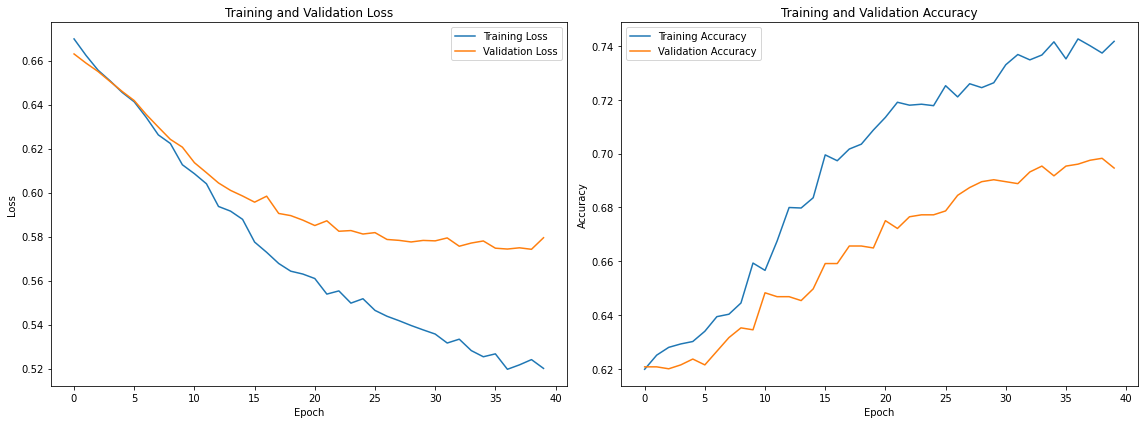

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# plot for training and validation loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot for training and validation accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [67]:
y_pred = model.predict(X_test)

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold is: {optimal_threshold}")

Optimal threshold is: 0.5720455050468445


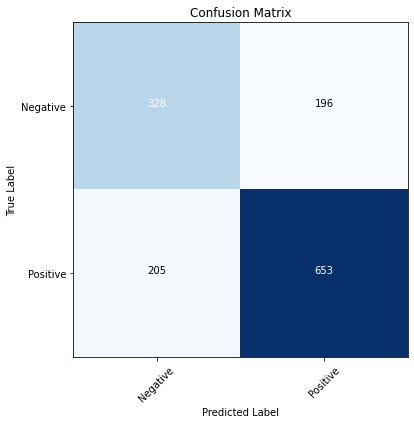

In [79]:
# predict the labels for the test set
y_pred_binary = (y_pred > optimal_threshold).astype(int)
# y_pred_binary = (y_pred > 0.7).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
# plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# add labels to the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

roc score: 0.7468549262442392


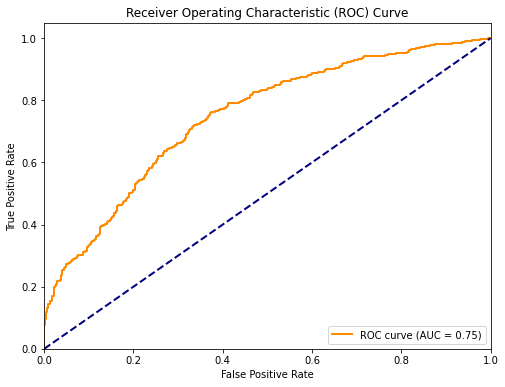

In [78]:
roc_auc = auc(fpr, tpr)
print(f"roc score: {roc_auc}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [87]:
# compute integrated gradients
def integrated_gradients(model, review_indices, baseline, steps=100):
    # get the embeddings for the review and baseline
    review_embeddings = get_embeddings(review_indices)
    baseline_embeddings = get_embeddings(baseline)

    # interpolate between the baseline and the review embeddings
    interpolated_embeddings = [
        baseline_embeddings + (step / steps) * (review_embeddings - baseline_embeddings)
        for step in range(steps + 1)
    ]

    # get the gradients of the model's output with respect to the input embeddings
    gradients = []
    for embeddings in interpolated_embeddings:
        embeddings_tensor = tf.convert_to_tensor(embeddings)
        with tf.GradientTape() as tape:
            tape.watch(embeddings_tensor)
            prediction = model(tf.expand_dims(embeddings_tensor, axis=0))
        gradients.append(tape.gradient(prediction, embeddings_tensor).numpy())

    # average the gradients
    avg_gradients = np.average(gradients[:-1], axis=0)

    # compute the integrated gradients
    integrated_grads = (review_embeddings - baseline_embeddings) * avg_gradients

    return integrated_grads

# select a random review to analyze
review_idx = random.randint(0, 1000)

review = truncated_reviews.iloc[review_idx]
print(f"Review Text: {review}")

# convert the review to indices
review_indices = review_to_indices(review)
print(f"Review Indices: {review_indices}")

baseline = np.zeros_like(review_indices)

# compute the integrated gradients
attribution_scores = integrated_gradients(model, review_indices, baseline)

# get the word indices with the highest attribution scores
top_indices = np.argsort(np.sum(attribution_scores, axis=1))[::-1][:3]

# predict the score for the review
review_embeddings = get_embeddings(review_indices)
score = model.predict(tf.expand_dims(review_embeddings, axis=0))
predicted_score = (score > optimal_threshold)[0][0].astype(int)

print(f"Actual review rating: {trunc_labels.iloc[review_idx]}")
print(f"Actual binary rating: {binarize_ratings(trunc_labels.iloc[review_idx])}")

# print the predicted score
print(f"Predicted binary Score: {predicted_score}")

# print the most influential words
print("\nMost influential words:")
for idx in top_indices:
    word = i2w[review_indices[idx]]
    print(f"{word}: {np.sum(attribution_scores[idx])}")

Review Text: ['software', 'well', 'known', 'excellent', 'provides', 'least', 'ten', 'times', 'capabilities', 'need', 'annual', 'licenses', 'reasonable', 'cost', 'since', 'amount', '20', 'per', 'user', 'licenses']
Review Indices: [ 634  334 1801    3  391  357 2173  244  904  256 4049 4004 2110  254
  374 3025 2419 3121  437 4004]
Actual review rating: 5.0
Actual binary rating: 1
Predicted binary Score: 1

Most influential words:
excellent: 0.01300194300711155
times: 0.010546241886913776
well: 0.0070205810479819775
